### Master of Applied Artificial Intelligence

**Course: TC4033 - Computational Vision for Images and Video**

<img src="./../assets/logo.png" alt="Image Alt Text" width="500"/>

**Image enhancement algorithms in the Fourier domain**

Tutor: Dr. Gilberto Ochoa


Team members:
* Alfonso de Lucas Espinosa - A01795118
* Ignacio Jose Aguilar Garcia - A00819762
* Alejandro Calderon Aguilar - A01795353
* Ricardo Mar Cupido - A01795394
* Mario Fonseca Martinez - A01795228


### Introduction

### Importing libraries

In [9]:
from matplotlib import image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image

### Loading Images

In [10]:
# Loading images

fingerprint = cv2.imread("data/fingerprint.png")
fingerprint_image = cv2.cvtColor(fingerprint, cv2.COLOR_BGR2GRAY)

In [11]:
def plot_images(images=[], labels=[], nrows=1, ncols=2, figsize=(12,8), cmap="gray"):
    """
    Plots a list of images in a grid layout using Matplotlib.

    Parameters:
    images (list): List of images to be plotted.
    labels (list): List of labels for each image. Default is an empty list.
    nrows (int): Number of rows in the grid. Default is 1.
    ncols (int): Number of columns in the grid. Default is 2.
    figsize (tuple): Size of the figure in inches. Default is (12, 8).
    cmap (str): Colormap to be used for displaying the images. Default is "gray".

    Returns:
    None
    """

    # set the subplots
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize)
    # Iterate over each axis defined in M*N as flat
    for i, ax in enumerate(axs.flat):
        # validates that the dimensions of axs fits with images array parameter
        if i < len(images):
            # plot the image
            ax.imshow(images[i], cmap=cmap)
            # if there are labels defined then set a title
            if len(labels) > 0:
                ax.set_title(labels[i])
            # dont show the axis ticks
            ax.axis("off")
        else:
            # dont show an empty plot
            ax.axis("off")
    # fits the plots
    plt.tight_layout()
    plt.show()


### 1. Application of image enhancement using Fourier transform with a low-pass filter.

In [12]:
def low_pass_filter(image, filter_type='ideal', D0=30, n=2):
    """
    Applies a low-pass filter to an image using Fourier transform.

    Parameters:
    image (numpy.ndarray): Input grayscale image.
    filter_type (str): Type of low-pass filter ('ideal', 'butterworth', 'gaussian').
    D0 (int): Cutoff frequency.
    n (int): Order of the Butterworth filter (only used if filter_type is 'butterworth').

    Returns:
    numpy.ndarray: Filtered image.
    """
    # Convert the image to grayscale if it is not already
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply Fourier transform
    dft = np.fft.fft2(image)
    dft_shift = np.fft.fftshift(dft)
    
    # Create the low-pass filter
    rows, cols = image.shape
    crow, ccol = rows // 2 , cols // 2
    mask = np.zeros((rows, cols), np.float32)
    
    if filter_type == 'ideal':
        for i in range(rows):
            for j in range(cols):
                if np.sqrt((i - crow)**2 + (j - ccol)**2) <= D0:
                    mask[i, j] = 1
    elif filter_type == 'butterworth':
        for i in range(rows):
            for j in range(cols):
                mask[i, j] = 1 / (1 + (np.sqrt((i - crow)**2 + (j - ccol)**2) / D0)**(2 * n))
    elif filter_type == 'gaussian':
        for i in range(rows):
            for j in range(cols):
                mask[i, j] = np.exp(-((i - crow)**2 + (j - ccol)**2) / (2 * (D0**2)))
    
    # Apply the filter
    dft_shift_filtered = dft_shift * mask
    
    # Inverse Fourier transform
    dft_shift_filtered = np.fft.ifftshift(dft_shift_filtered)
    img_back = np.fft.ifft2(dft_shift_filtered)
    img_back = np.abs(img_back)
    
    return img_back


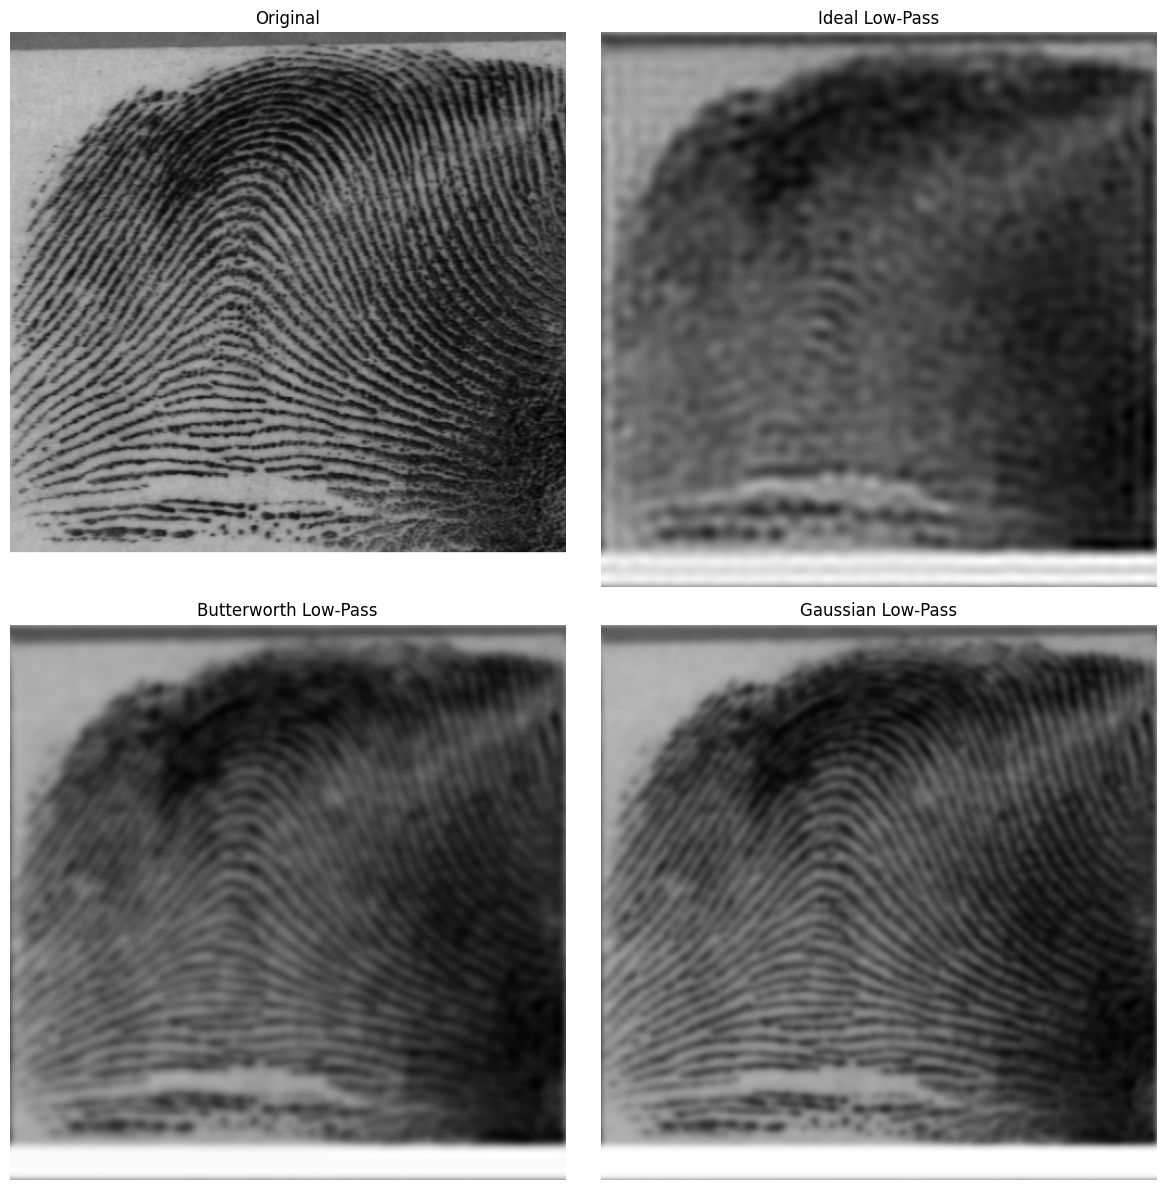

In [13]:
# Load the image
image = fingerprint_image.copy()


# Apply the filters
ideal_filtered = low_pass_filter(image, filter_type='ideal', D0=30)
butterworth_filtered = low_pass_filter(image, filter_type='butterworth', D0=30, n=2)
gaussian_filtered = low_pass_filter(image, filter_type='gaussian', D0=30)

# Display the images
images = [image, ideal_filtered, butterworth_filtered, gaussian_filtered]
labels = ['Original', 'Ideal Low-Pass', 'Butterworth Low-Pass', 'Gaussian Low-Pass']
plot_images(images, labels, nrows=2, ncols=2, figsize=(12, 12))


### 2. Application of image enhancement using Fourier transform with a high-pass filter.

In [16]:
# Function to apply high-pass filter
def high_pass_filter(image, filter_type='ideal', D0=30, n=2):
    """
    Applies a high-pass filter to an image using Fourier transform.

    Parameters:
    image (numpy.ndarray): Input grayscale image.
    filter_type (str): Type of high-pass filter ('ideal', 'butterworth', 'gaussian').
    D0 (int): Cutoff frequency.
    n (int): Order of the Butterworth filter (only used if filter_type is 'butterworth').

    Returns:
    numpy.ndarray: Filtered image.
    """
    # Convert the image to grayscale if it is not already
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply Fourier transform
    dft = np.fft.fft2(image)
    dft_shift = np.fft.fftshift(dft)
    
    # Create the high-pass filter
    rows, cols = image.shape
    crow, ccol = rows // 2 , cols // 2
    mask = np.ones((rows, cols), np.float32)
    if filter_type == 'ideal':
        for i in range(rows):
            for j in range(cols):
                if np.sqrt((i - crow)**2 + (j - ccol)**2) <= D0:
                    mask[i, j] = 0
    elif filter_type == 'butterworth':
        for i in range(rows):
            for j in range(cols):
                distance = np.sqrt((i - crow)**2 + (j - ccol)**2)
                if distance == 0:
                    mask[i, j] = 0
                else:
                    mask[i, j] = 1 / (1 + (D0 / distance)**(2 * n))
    elif filter_type == 'gaussian':
        for i in range(rows):
            for j in range(cols):
                mask[i, j] = 1 - np.exp(-((i - crow)**2 + (j - ccol)**2) / (2 * (D0**2)))
    
    # Apply the filter
    dft_shift_filtered = dft_shift * mask
    
    # Inverse Fourier transform
    dft_shift_filtered = np.fft.ifftshift(dft_shift_filtered)
    img_back = np.fft.ifft2(dft_shift_filtered)
    img_back = np.abs(img_back)
    
    return img_back

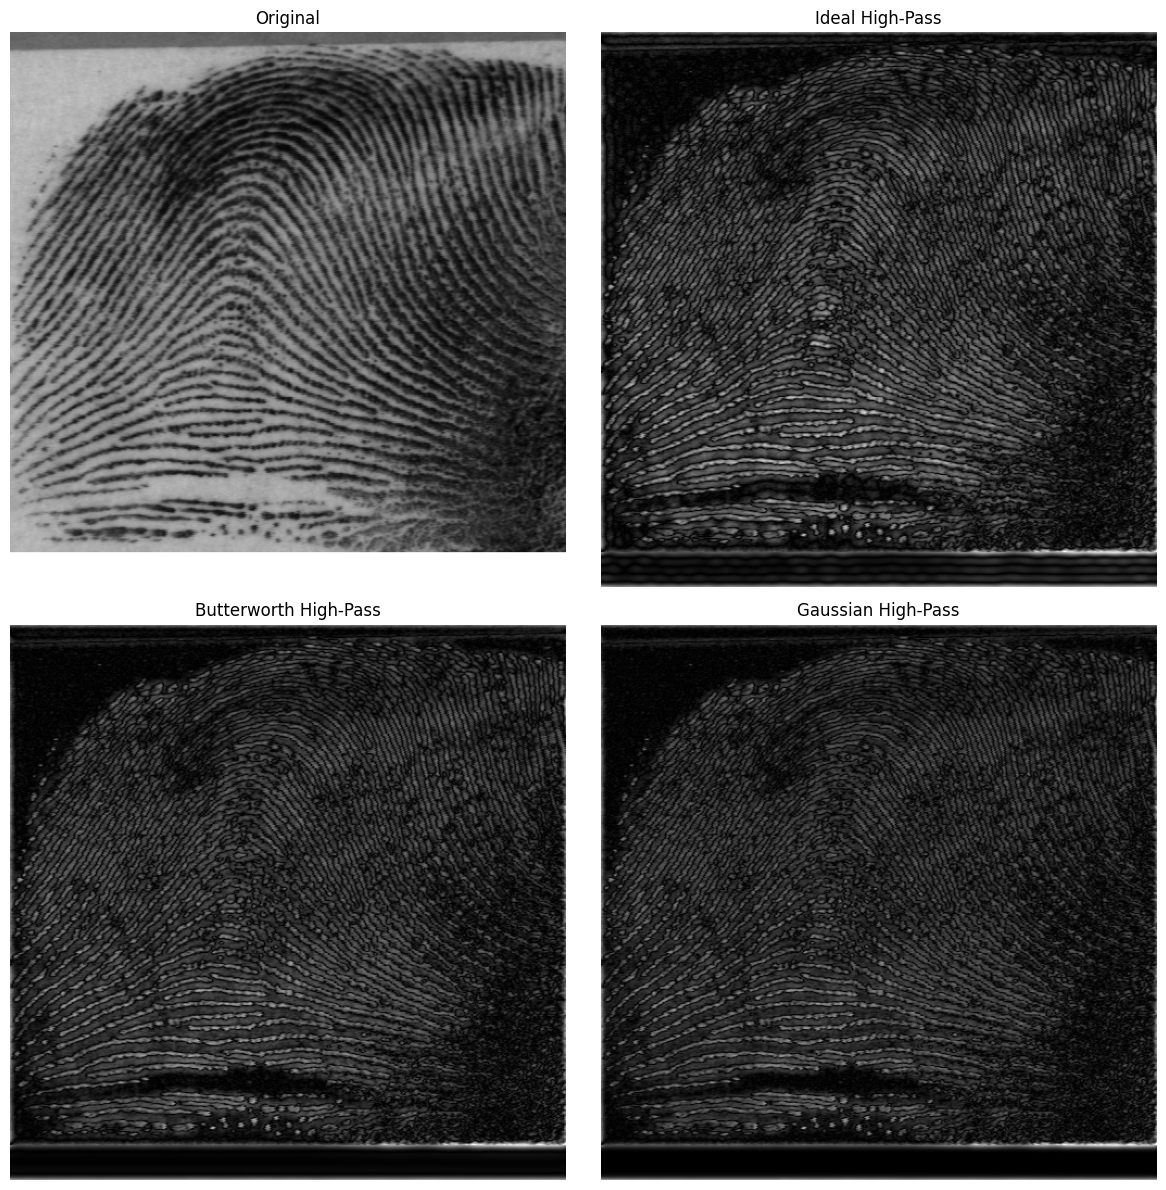

In [18]:
# Load the image
image = fingerprint_image.copy()

# Apply the filters
ideal_filtered = high_pass_filter(image, filter_type='ideal', D0=30)
butterworth_filtered = high_pass_filter(image, filter_type='butterworth', D0=30, n=2)
gaussian_filtered = high_pass_filter(image, filter_type='gaussian', D0=30)

# Display the images
images = [image, ideal_filtered, butterworth_filtered, gaussian_filtered]
labels = ['Original', 'Ideal High-Pass', 'Butterworth High-Pass', 'Gaussian High-Pass']
plot_images(images, labels, nrows=2, ncols=2, figsize=(12, 12))

### Conclusion

### References
